In [8]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tikzplotlib as tpl
import tqdm
from scipy.integrate import quad
import scipy.stats as stats

from core.temperature_scaling import find_optimal_temperature_logit_teacher
from core.utility import probit, sigmoid_inv, KERNEL_COEFICIENTS, get_additional_noise_from_kappas
import core.utility as over_utility

import gcmpyo3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Compare three estimators first : 
* ERM at $\lambda = 0$
* Empirical Bayes with $\beta = 1$, $\lambda$ optimized for evidence
* Finite temperature sampling of ERM with $\beta$ optimized for error at $\lambda = 0$

In [9]:
# DEFINE THE PARAMETERS 

lambda_0 = 1e-4
beta_evidence = 1.0

# can be rho = 1.0
rho        = 1.0
n_over_p   = 2.0
noise_std  = 0.5
noise_var  = noise_std**2
activation = "erf"
data_model = "logit"

kappa0, kappa1, kappastar = over_utility.KERNEL_COEFICIENTS[activation]

In [10]:
# DEFINE THE STATE EVOLUTION PARAMS

erm_se_tolerance       = 1e-8
erm_relative_tolerance = False

pb_se_tolerance        = 1e-4
pb_relative_tolerance  = True

In [11]:
inv_alpha_range_for_lambda_0 = np.linspace(0.1, 5.0, 100)
alpha_range_for_lambda_0     = 1.0 / inv_alpha_range_for_lambda_0

In [14]:
# 1) Compute the overlaps for lambda = 0 and save them 

ms_for_lambda_0 = []
qs_for_lambda_0 = []
vs_for_lambda_0 = []
mhats_for_lambda_0 = []
qhats_for_lambda_0 = []
vhats_for_lambda_0 = []


for inv_alpha in tqdm.tqdm(inv_alpha_range_for_lambda_0):
    gamma = n_over_p * inv_alpha
    alpha = 1.0 / inv_alpha 
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, lambda_0, rho, data_model, erm_se_tolerance, erm_relative_tolerance)
    ms_for_lambda_0.append(m)
    qs_for_lambda_0.append(q)
    vs_for_lambda_0.append(v)
    mhats_for_lambda_0.append(mhat)
    qhats_for_lambda_0.append(qhat)
    vhats_for_lambda_0.append(vhat)


  7%|▋         | 7/100 [00:07<02:48,  1.81s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.000004848511049093673 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.023598627423714102 / 0.00000001, relative tol. is false


  9%|▉         | 9/100 [00:16<04:50,  3.19s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.07429798128539478 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.11931946673529392 / 0.00000001, relative tol. is false


 11%|█         | 11/100 [00:23<04:44,  3.20s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.010791043542607959 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.001248881233417265 / 0.00000001, relative tol. is false


 13%|█▎        | 13/100 [00:29<04:28,  3.09s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.00024033567715875392 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.000049892252042660346 / 0.00000001, relative tol. is false


 16%|█▌        | 16/100 [00:37<04:04,  2.91s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.000006295832973179927 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.000001220125737777522 / 0.00000001, relative tol. is false


 17%|█▋        | 17/100 [00:40<03:58,  2.87s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.000000599854228067187 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.0000002008761290639427 / 0.00000001, relative tol. is false


 19%|█▉        | 19/100 [00:45<03:44,  2.77s/it]

Reached MAX_ITER_ERM in state evolution : last difference was 0.0000000608875305729839 / 0.00000001, relative tol. is false
Reached MAX_ITER_ERM in state evolution : last difference was 0.000000017813599484384213 / 0.00000001, relative tol. is false


100%|██████████| 100/100 [47:59<00:00, 28.79s/it]  


---

### Bayes optimal

In [15]:
alpha_range_for_bayes_optimal = np.array(alpha_range_for_lambda_0)
inv_alpha_range_for_bayes_optimal = 1.0 / alpha_range_for_bayes_optimal

In [16]:

# 1) Compute the overlaps for lambda = 0 and save them 

ms_for_bayes_optimal = []
qs_for_bayes_optimal = []
vs_for_bayes_optimal = []
mhats_for_bayes_optimal = []
qhats_for_bayes_optimal = []
vhats_for_bayes_optimal = []


for alpha in tqdm.tqdm(alpha_range_for_bayes_optimal):
    gamma = n_over_p / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.bayes_optimal_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, rho, "logit", 1e-6, False, False)
    ms_for_bayes_optimal.append(m)
    qs_for_bayes_optimal.append(q)
    vs_for_bayes_optimal.append(v)
    mhats_for_bayes_optimal.append(mhat)
    qhats_for_bayes_optimal.append(qhat)
    vhats_for_bayes_optimal.append(vhat)

100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


*Bayes optimal on the teacher's data*

In [17]:
# In the matched case + logit data, pseudo bayes with beta = corresponding to the noise, lambda = 1.0 / rho <=> Bayes optimal
m_bo, q_bo, v_bo, mhat_bo, qhat_bo, vhat_bo = gcmpyo3.state_evolution.bayes_optimal_state_evolution_matching(n_over_p, noise_var, rho, "logit", pb_se_tolerance, pb_relative_tolerance, verbose = False)

---

### Empirical bayes : evidence maximization

In [18]:
# 2) Load the optimal lambdas for evidence (with lambda = 1)

df = pd.read_csv("data/lambda_evidence.csv")

lambda_evidence = df['lambda']
alpha_range_for_lambda_evidence = df['alpha']
inv_alpha_range_for_lambda_evidence = 1.0 / alpha_range_for_lambda_evidence

In [19]:
ms_for_lambda_evidence = []
qs_for_lambda_evidence = []
vs_for_lambda_evidence = []

mhats_for_lambda_evidence = []
qhats_for_lambda_evidence = []
vhats_for_lambda_evidence = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_lambda_evidence)):
    gamma = n_over_p / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.pseudo_bayes_state_evolution_gcm(alpha, beta_evidence, noise_var, gamma, kappa1, kappastar, lambda_evidence[i], rho, data_model, pb_se_tolerance, pb_relative_tolerance, normalized = True, verbose = False)
    ms_for_lambda_evidence.append(m)
    qs_for_lambda_evidence.append(q)
    vs_for_lambda_evidence.append(v)
    mhats_for_lambda_evidence.append(mhat)
    qhats_for_lambda_evidence.append(qhat)
    vhats_for_lambda_evidence.append(vhat)

100it [00:12,  7.72it/s]


---

### Empirical Bayes : error cross-validation

In [20]:
# 2) Load the optimal lambdas for error (with beta = 1)

df = pd.read_csv("data/pb_lambda_error.csv")

pb_lambda_error = df['lambda']
alpha_range_for_pb_lambda_error = df['alpha']
inv_alpha_range_for_pb_lambda_error = 1.0 / alpha_range_for_pb_lambda_error

In [21]:
ms_for_pb_lambda_error = []
qs_for_pb_lambda_error = []
vs_for_pb_lambda_error = []

mhats_for_pb_lambda_error = []
qhats_for_pb_lambda_error = []
vhats_for_pb_lambda_error = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_pb_lambda_error)):
    gamma = n_over_p / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.pseudo_bayes_state_evolution_gcm(alpha, beta_evidence, noise_var, gamma, kappa1, kappastar, pb_lambda_error[i], rho, data_model, pb_se_tolerance, pb_relative_tolerance, normalized = True, verbose = False)
    ms_for_pb_lambda_error.append(m)
    qs_for_pb_lambda_error.append(q)
    vs_for_pb_lambda_error.append(v)
    mhats_for_pb_lambda_error.append(mhat)
    qhats_for_pb_lambda_error.append(qhat)
    vhats_for_pb_lambda_error.append(vhat)

100it [00:15,  6.59it/s]


---

### ERM lambda error

In [22]:
df = pd.read_csv("data/erm_lambda_error.csv")
erm_lambda_error = df['lambda']
alpha_range_for_erm_lambda_error = df['alpha']
inv_alpha_range_for_erm_lambda_error = 1.0 / alpha_range_for_erm_lambda_error

In [23]:
ms_for_erm_lambda_error = []
qs_for_erm_lambda_error = []
vs_for_erm_lambda_error = []

mhats_for_erm_lambda_error = []
qhats_for_erm_lambda_error = []
vhats_for_erm_lambda_error = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_erm_lambda_error)):
    gamma = n_over_p / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, erm_lambda_error[i], rho, data_model, erm_se_tolerance, erm_relative_tolerance)
    ms_for_erm_lambda_error.append(m)
    qs_for_erm_lambda_error.append(q)
    vs_for_erm_lambda_error.append(v)
    mhats_for_erm_lambda_error.append(mhat)
    qhats_for_erm_lambda_error.append(qhat)
    vhats_for_erm_lambda_error.append(vhat)

100it [00:09, 10.25it/s]


--- 

### ERM lambda loss

In [24]:
df = pd.read_csv("data/erm_lambda_loss.csv")
erm_lambda_loss = df['lambda']
alpha_range_for_erm_lambda_loss = df['alpha']
inv_alpha_range_for_erm_lambda_loss = 1.0 / alpha_range_for_erm_lambda_loss

In [25]:
ms_for_erm_lambda_loss = []
qs_for_erm_lambda_loss = []
vs_for_erm_lambda_loss = []

mhats_for_erm_lambda_loss = []
qhats_for_erm_lambda_loss = []
vhats_for_erm_lambda_loss = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_erm_lambda_loss)):
    gamma = n_over_p / alpha
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, erm_lambda_loss[i], rho, data_model, erm_se_tolerance, erm_relative_tolerance)
    ms_for_erm_lambda_loss.append(m)
    qs_for_erm_lambda_loss.append(q)
    vs_for_erm_lambda_loss.append(v)
    mhats_for_erm_lambda_loss.append(mhat)
    qhats_for_erm_lambda_loss.append(qhat)
    vhats_for_erm_lambda_loss.append(vhat)

100it [00:05, 17.06it/s]


---

### Compare the test errors

In [26]:
error_lambda_0        = [over_utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_lambda_0, qs_for_lambda_0)]
error_bayes_optimal   = [over_utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_bayes_optimal, qs_for_bayes_optimal)]
error_lambda_evidence = [over_utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_lambda_evidence, qs_for_lambda_evidence)]
error_pb_lambda_error = [over_utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_pb_lambda_error, qs_for_pb_lambda_error)]
error_erm_lambda_error = [over_utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error)]
error_erm_lambda_loss = [over_utility.generalisation_error_logit_teacher(rho, m, q, noise_std) for m, q in zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss)]

In [27]:
error_matched_bayes_optimal = over_utility.generalisation_error_logit_teacher(rho, m_bo, q_bo, noise_std)
error_teacher               = over_utility.generalisation_error_logit_teacher(rho, rho, rho, noise_std)

Text(0, 0.5, '$\\varepsilon_g$')

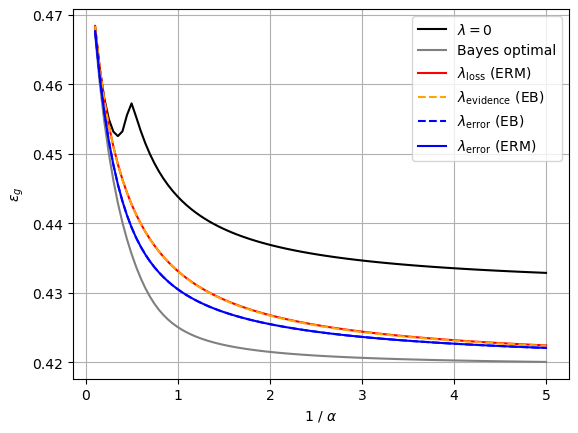

In [28]:
plt.plot(inv_alpha_range_for_lambda_0, error_lambda_0, label='$\\lambda = 0$', c = 'k')
plt.plot(inv_alpha_range_for_bayes_optimal, error_bayes_optimal, label='Bayes optimal', c = 'gray')
plt.plot(inv_alpha_range_for_erm_lambda_loss, error_erm_lambda_loss, 'r', label='$\\lambda_{\\rm loss}$ (ERM)')
plt.plot(inv_alpha_range_for_lambda_evidence, error_lambda_evidence, '--', label='$\\lambda_{\\rm evidence}$ (EB)', c = 'orange')
plt.plot(inv_alpha_range_for_pb_lambda_error, error_pb_lambda_error, 'b--', label='$\\lambda_{\\rm error}$ (EB)')
plt.plot(inv_alpha_range_for_erm_lambda_error, error_erm_lambda_error, 'b', label='$\\lambda_{\\rm error}$ (ERM)')
plt.legend()
plt.grid()

plt.xlabel('1 / $ \\alpha $')
plt.ylabel('$\\varepsilon_g$')

---

### Calibration

In [32]:
level = 0.75
add_vars_bayes_optimal = [over_utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_p * inv_alpha) for inv_alpha in inv_alpha_range_for_bayes_optimal]
add_vars_evidence = [over_utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_p * inv_alpha) for inv_alpha in inv_alpha_range_for_lambda_evidence]
add_vars_eb_error = [over_utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_p * inv_alpha) for inv_alpha in inv_alpha_range_for_pb_lambda_error]
add_vars_error    = [over_utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_p * inv_alpha) for inv_alpha in inv_alpha_range_for_erm_lambda_error]
add_vars_loss     = [over_utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_p * inv_alpha) for inv_alpha in inv_alpha_range_for_erm_lambda_loss]
add_vars_0        = [over_utility.get_additional_noise_from_kappas(kappa1, kappastar, n_over_p * inv_alpha) for inv_alpha in inv_alpha_range_for_lambda_0]


In [36]:
# Compute the noise variance for Laplace 

variance_laplace_lambda_0     = [ over_utility.omega_inv_hessian_trace_random_features(kappa1, kappastar, n_over_p * inv_alpha, 1e-4, vhat) for inv_alpha, vhat in zip(inv_alpha_range_for_lambda_0, vhats_for_lambda_0) ]
variance_laplace_lambda_error = [ over_utility.omega_inv_hessian_trace_random_features(kappa1, kappastar, n_over_p * inv_alpha, lambda_, vhat) for inv_alpha, lambda_, vhat in zip(inv_alpha_range_for_erm_lambda_error, erm_lambda_error, vhats_for_erm_lambda_error) ]
variance_laplace_lambda_loss  = [ over_utility.omega_inv_hessian_trace_random_features(kappa1, kappastar, n_over_p * inv_alpha, lambda_, vhat) for inv_alpha, lambda_, vhat in zip(inv_alpha_range_for_erm_lambda_loss, erm_lambda_loss, vhats_for_erm_lambda_loss) ]


In [33]:
# NOTE : small difference w/ and w/o the additional noise, prolly due to the probit approximation
level = 0.75

calibration_lambda_0      = [ over_utility.calibration_logit_teacher(level, m ,q, rho - add_var, 0.0, noise_var + add_var) for m, q, add_var in tqdm.tqdm(zip(ms_for_lambda_0, qs_for_lambda_0, add_vars_0))]
calibration_bayes_optimal = [ over_utility.calibration_logit_teacher(level, m ,q, rho, rho - q + noise_var, noise_var) for m, q in tqdm.tqdm(zip(ms_for_bayes_optimal, qs_for_bayes_optimal))]
calibration_lambda_evidence = [over_utility.calibration_logit_teacher(level, m ,q, rho, v, noise_var) for m, q, v in tqdm.tqdm(zip(ms_for_lambda_evidence, qs_for_lambda_evidence, vs_for_lambda_evidence))]
calibration_pb_lambda_error = [over_utility.calibration_logit_teacher(level, m ,q, rho, v, noise_var) for m, q, v in tqdm.tqdm(zip(ms_for_pb_lambda_error, qs_for_pb_lambda_error, vs_for_pb_lambda_error))]
calibration_erm_lambda_error= [over_utility.calibration_logit_teacher(level, m ,q, rho, 0.0, noise_var) for m, q in tqdm.tqdm(zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error))]
calibration_erm_lambda_loss = [over_utility.calibration_logit_teacher(level, m ,q, rho, 0.0, noise_var) for m, q, add_var in tqdm.tqdm(zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss, add_vars_loss))]

100it [00:00, 174908.42it/s]
100it [00:00, 14844.99it/s]
100it [00:00, 16255.10it/s]
100it [00:00, 15632.31it/s]
100it [00:00, 142663.40it/s]
100it [00:00, 178633.05it/s]


In [37]:
calibration_laplace_lambda_error = [over_utility.calibration_logit_teacher(level, m, q, rho, var, noise_var) for m, q, var in tqdm.tqdm(zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error, variance_laplace_lambda_error))]
calibration_laplace_lambda_loss  = [over_utility.calibration_logit_teacher(level, m, q, rho, var, noise_var) for m, q, var in tqdm.tqdm(zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss, variance_laplace_lambda_loss))]
calibration_laplace_lambda_0     = [over_utility.calibration_logit_teacher(level, m, q, rho, var, noise_var) for m, q, var in tqdm.tqdm(zip(ms_for_lambda_0, qs_for_lambda_0, variance_laplace_lambda_0))]

100it [00:00, 14017.46it/s]
100it [00:00, 13902.23it/s]
100it [00:00, 8814.53it/s]


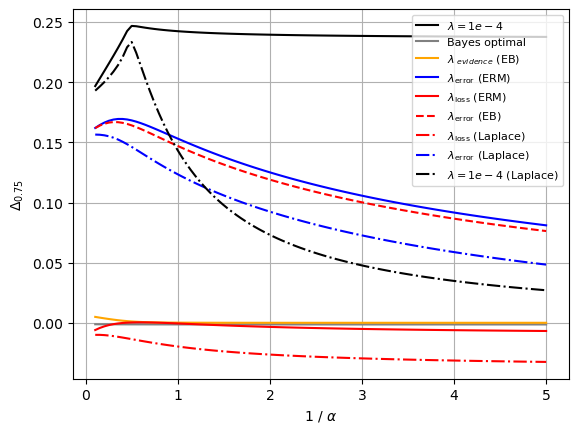

In [38]:
plt.plot(inv_alpha_range_for_lambda_0, calibration_lambda_0, 'k', label='$\\lambda = 1e-4$')
plt.plot(inv_alpha_range_for_bayes_optimal, calibration_bayes_optimal, c='gray', label='Bayes optimal')
plt.plot(inv_alpha_range_for_lambda_evidence, calibration_lambda_evidence, c = 'orange', label='$\\lambda_{\\ evidence}$ (EB)')
plt.plot(inv_alpha_range_for_erm_lambda_error, calibration_erm_lambda_error, c = 'b', label='$\\lambda_{\\rm error}$ (ERM)')
plt.plot(inv_alpha_range_for_erm_lambda_loss, calibration_erm_lambda_loss, c = 'r', label='$\\lambda_{\\rm loss}$ (ERM)')
plt.plot(inv_alpha_range_for_pb_lambda_error, calibration_pb_lambda_error, 'r--', label='$\\lambda_{\\rm error}$ (EB)')
plt.plot(inv_alpha_range_for_erm_lambda_loss, calibration_laplace_lambda_loss, 'r-.', label='$\\lambda_{\\rm loss}$ (Laplace)')
plt.plot(inv_alpha_range_for_erm_lambda_error, calibration_laplace_lambda_error, 'b-.', label='$\\lambda_{\\rm error}$ (Laplace)')
plt.plot(inv_alpha_range_for_lambda_0, calibration_laplace_lambda_0, 'k-.', label='$\\lambda = 1e-4$ (Laplace)')

plt.legend()
plt.grid()

plt.xlabel('1 / $\\alpha$')
plt.ylabel('$\\Delta_{' + str(level) + '}$')

plt.legend(prop={'size': 8})

---

# Conditional variance


In [39]:
# Conditional variance of the Bayes Optimal

bayes_optimal_cond_variance_lambda_0        = [over_utility.conditional_variance_logit_teacher(level, m, q, qbo, 0.0, vbo + noise_var + add_var) for m, q, qbo, vbo, add_var in zip(ms_for_lambda_0, qs_for_lambda_0, qs_for_bayes_optimal, vs_for_bayes_optimal, add_vars_0)]
bayes_optimal_cond_variance_lambda_error    = [over_utility.conditional_variance_logit_teacher(level, m, q, qbo, 0.0, vbo + noise_var + add_var) for m, q, qbo,vbo, add_var in zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error, qs_for_bayes_optimal, vs_for_bayes_optimal, add_vars_error)]
bayes_optimal_cond_variance_eb_lambda_error = [over_utility.conditional_variance_logit_teacher(level, m, q, qbo, 0.0, vbo + noise_var + add_var) for m, q, qbo,vbo, add_var in zip(ms_for_pb_lambda_error, qs_for_pb_lambda_error, qs_for_bayes_optimal, vs_for_bayes_optimal, add_vars_eb_error)]
bayes_optimal_cond_variance_lambda_loss     = [over_utility.conditional_variance_logit_teacher(level, m, q, qbo, 0.0, vbo + noise_var + add_var) for m, q, qbo,vbo, add_var in zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss, qs_for_bayes_optimal, vs_for_bayes_optimal, add_vars_loss)]
bayes_optimal_cond_variance_lambda_evidence = [over_utility.conditional_variance_logit_teacher(level, m, q, qbo, v, vbo + noise_var + add_var) for m, q, v, qbo, vbo,  add_var in zip(ms_for_lambda_evidence, qs_for_lambda_evidence, vs_for_lambda_evidence, qs_for_bayes_optimal,  vs_for_bayes_optimal, add_vars_evidence)]

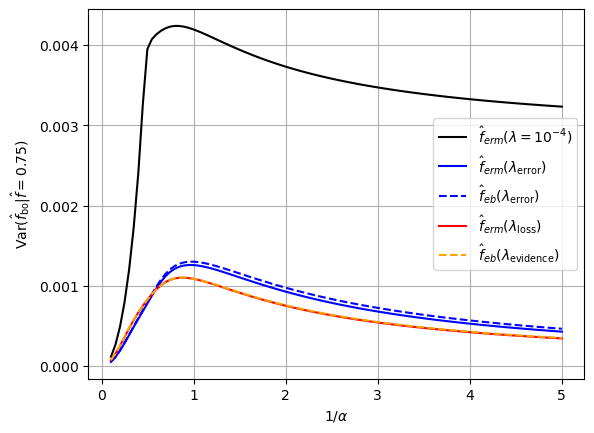

In [40]:
plt.plot(inv_alpha_range_for_lambda_0, bayes_optimal_cond_variance_lambda_0, c='k', label='$\\hat{f}_{erm}(\\lambda = 10^{-4})$')
plt.plot(inv_alpha_range_for_erm_lambda_error, bayes_optimal_cond_variance_lambda_error, c='b', label='$\\hat{f}_{erm}(\\lambda_{\\rm error})$')
plt.plot(inv_alpha_range_for_pb_lambda_error, bayes_optimal_cond_variance_eb_lambda_error, 'b--', label='$\\hat{f}_{eb}(\\lambda_{\\rm error})$')
plt.plot(inv_alpha_range_for_erm_lambda_loss, bayes_optimal_cond_variance_lambda_loss, 'r', label='$\\hat{f}_{erm}(\\lambda_{\\rm loss})$')
plt.plot(inv_alpha_range_for_lambda_evidence, bayes_optimal_cond_variance_lambda_evidence, '--', c='orange', label='$\\hat{f}_{eb}(\\lambda_{\\rm evidence})$')

plt.xlabel('$1 / \\alpha$')
plt.ylabel('${\\rm Var}(\\hat{f}_{\\rm bo} | \\hat{f} = ' + str(level) + ')$')

plt.grid()
plt.legend()

---

# Temperature scaling

In [41]:
# for lambda = 0

temps_opts_lambda_0 = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_lambda_0)):
    m, q = ms_for_lambda_0[i], qs_for_lambda_0[i]
    temp_opt = find_optimal_temperature_logit_teacher(rho, m, q, noise_var, t_mini = 0.01, t_maxi = 100.0)
    temps_opts_lambda_0.append(temp_opt)

35it [00:05,  5.95it/s]


KeyboardInterrupt: 

In [ ]:
# for lambda = error

temps_opts_lambda_error = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_erm_lambda_error)):
    m, q = ms_for_erm_lambda_error[i], qs_for_erm_lambda_error[i]
    temp_opt = find_optimal_temperature_logit_teacher(rho, m, q, noise_var, t_mini = 0.01, t_maxi = 100.0)
    temps_opts_lambda_error.append(temp_opt)

100it [00:21,  4.58it/s]


In [ ]:
# for lambda_loss

temps_opts_lambda_loss = []

for i, alpha in tqdm.tqdm(enumerate(alpha_range_for_erm_lambda_loss)):
    m, q = ms_for_erm_lambda_loss[i], qs_for_erm_lambda_loss[i]
    temp_opt = find_optimal_temperature_logit_teacher(rho, m, q, noise_var, t_mini = 0.01, t_maxi = 100.0)
    temps_opts_lambda_loss.append(temp_opt)

100it [00:22,  4.40it/s]


--

In [ ]:
ece_with_temp_scaling_lambda_0 = []

for i in tqdm.tqdm(range(len(alpha_range_for_lambda_0))):
    alpha = alpha_range_for_lambda_0[i]
    m, q, temp  = ms_for_lambda_0[i], qs_for_lambda_0[i], temps_opts_lambda_0[i]
    ece = over_utility.ece_logit_teacher(m / temp, q / temp**2, rho, 0.0, noise_var, upper_bound = 1 - 1e-16)
    ece_with_temp_scaling_lambda_0.append(ece)


100%|██████████| 100/100 [00:01<00:00, 76.72it/s]


In [ ]:
ece_with_temp_scaling_lambda_error = []

for i in tqdm.tqdm(range(len(alpha_range_for_lambda_0))):
    alpha = alpha_range_for_lambda_0[i]
    m, q, temp = ms_for_erm_lambda_error[i], qs_for_erm_lambda_error[i], temps_opts_lambda_error[i]
    ece = over_utility.ece_logit_teacher(m / temp, q / temp**2, rho, 0.0, noise_var, upper_bound = 1 - 1e-16)
    ece_with_temp_scaling_lambda_error.append(ece)


100%|██████████| 100/100 [00:01<00:00, 75.63it/s]


In [ ]:
ece_with_temp_scaling_lambda_loss = []

for i in tqdm.tqdm(range(len(alpha_range_for_erm_lambda_loss))):
    alpha = alpha_range_for_erm_lambda_loss[i]
    m, q, temp = ms_for_erm_lambda_loss[i], qs_for_erm_lambda_loss[i], temps_opts_lambda_loss[i]
    ece = over_utility.ece_logit_teacher(m / temp, q / temp**2, rho, 0.0, noise_var, upper_bound = 1 - 1e-16)
    ece_with_temp_scaling_lambda_loss.append(ece)


100%|██████████| 100/100 [00:01<00:00, 71.25it/s]


--

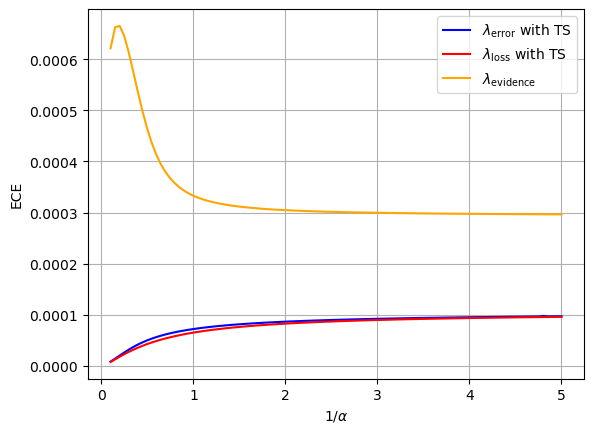

In [ ]:
plt.plot(inv_alpha_range_for_erm_lambda_error, ece_with_temp_scaling_lambda_error, 'b', label='$\\lambda_{\\rm error}$ with TS')
plt.plot(inv_alpha_range_for_erm_lambda_loss, ece_with_temp_scaling_lambda_loss, 'r', label='$\\lambda_{\\rm loss}$ with TS')
plt.plot(inv_alpha_range_for_lambda_evidence, ece_lambda_evidence, c='orange', label='$\\lambda_{\\rm evidence}$')

plt.legend()
plt.xlabel('$1 / \\alpha$')
plt.ylabel('ECE')

plt.grid()

tpl.save(f'ece_temp_scaling_n_over_p={n_over_p}.tex', axis_width=r'\figwidth', axis_height=r'\figheight')

--

In [ ]:
# Compute the calibration after temperature scaling

level = 0.75

calibration_with_temp_scaling_lambda_0      = [ over_utility.calibration_logit_teacher(level,  m / temp , q / temp**2, rho, 0.0, noise_var) for m, q, temp in tqdm.tqdm(zip(ms_for_lambda_0, qs_for_lambda_0, temps_opts_lambda_0))]
calibration_with_temp_scaling_erm_lambda_error= [over_utility.calibration_logit_teacher(level, m / temp , q / temp**2, rho, 0.0, noise_var) for m, q, temp in tqdm.tqdm(zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error, temps_opts_lambda_error))]
calibration_with_temp_scaling_erm_lambda_loss = [over_utility.calibration_logit_teacher(level, m / temp , q / temp**2, rho, 0.0, noise_var) for m, q, temp in tqdm.tqdm(zip(ms_for_erm_lambda_loss, qs_for_erm_lambda_loss, temps_opts_lambda_loss))]
calibration_lambda_evidence = [over_utility.calibration_logit_teacher(level, m ,q, rho, v, noise_var) for m, q, v in tqdm.tqdm(zip(ms_for_lambda_evidence, qs_for_lambda_evidence, vs_for_lambda_evidence))]

[autoreload of gcmpyo3 failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/gcmpyo3/__init__.py", line 3, in <module>
    __doc__ = gcmpyo3.__doc__
NameError: name 'gcmpyo3' is not defined
]


NameError: name 'temps_opts_lambda_0' is not defined

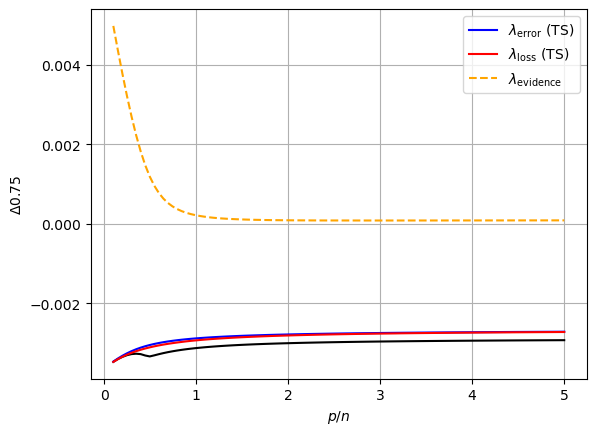

In [ ]:
plt.plot(inv_alpha_range_for_lambda_0, calibration_with_temp_scaling_lambda_0, c='k')
plt.plot(inv_alpha_range_for_erm_lambda_error, calibration_with_temp_scaling_erm_lambda_error, 'b', label='$\\lambda_{\\rm error}$ (TS)')
plt.plot(inv_alpha_range_for_erm_lambda_loss, calibration_with_temp_scaling_erm_lambda_loss, 'r', label='$\\lambda_{\\rm loss}$ (TS)')
plt.plot(inv_alpha_range_for_lambda_evidence, calibration_lambda_evidence, '--', c='orange', label='$\\lambda_{\\rm evidence}$')

plt.xlabel('$p/n$')
plt.ylabel(f'$\\Delta${level}')

plt.grid()
plt.legend()

--

In [ ]:
# Compute the conditional variance after temperature scaling

level = 0.75 
bo_cond_variance_temp_scaling_error = [over_utility.conditional_variance_logit_teacher(level, m / temp, q / temp**2, qbo, 0.0, vbo + noise_var + add_var) for m, q, temp, add_var, qbo, vbo in zip(ms_for_erm_lambda_error, qs_for_erm_lambda_error, temps_opts_lambda_error, add_vars_error, qs_for_bayes_optimal, vs_for_bayes_optimal)]
bo_cond_variance_temp_scaling_loss  = [over_utility.conditional_variance_logit_teacher(level, m / temp, q / temp**2, qbo, 0.0, vbo + noise_var + add_var) for m, q, temp, add_var, qbo, vbo in zip(ms_for_erm_lambda_loss , qs_for_erm_lambda_loss , temps_opts_lambda_loss , add_vars_loss , qs_for_bayes_optimal, vs_for_bayes_optimal)]
bo_cond_variance_temp_scaling_0     = [over_utility.conditional_variance_logit_teacher(level, m / temp, q / temp**2, qbo, 0.0, vbo + noise_var + add_var) for m, q, temp, add_var, qbo, vbo in zip(ms_for_lambda_0 , qs_for_lambda_0 , temps_opts_lambda_0 , add_vars_0 , qs_for_bayes_optimal, vs_for_bayes_optimal)]

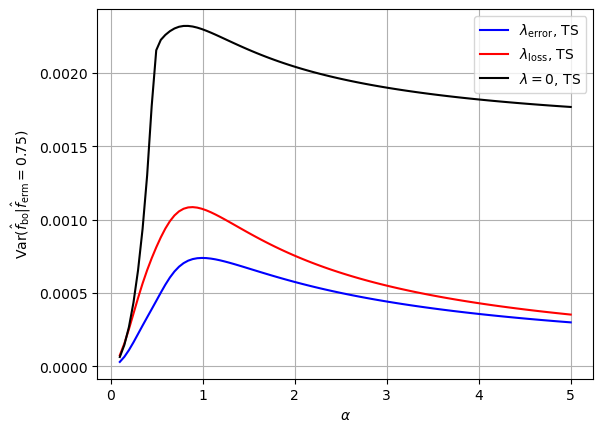

In [ ]:
plt.plot(inv_alpha_range_for_erm_lambda_error, bo_cond_variance_temp_scaling_error, 'b', label='$\\lambda_{\\rm error}$, TS')
plt.plot(inv_alpha_range_for_erm_lambda_loss, bo_cond_variance_temp_scaling_loss, 'r', label='$\\lambda_{\\rm loss}$, TS')
plt.plot(inv_alpha_range_for_lambda_0, bo_cond_variance_temp_scaling_0, 'k', label='$\\lambda = 0$, TS')

plt.grid()
plt.legend()

plt.xlabel('$\\alpha$')
plt.ylabel('Var($\\hat{f}_{\\rm bo} | \\hat{f}_{\\rm erm} = 0.75$)')